# Import Libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import numpy as np

# Obtain Data

Read AirQualityUCI.csv into pandas and isolate PT08.S3(NOx) column for time series

In [79]:
df = pd.read_csv('AirQualityUCI.csv', delimiter=';')
df['Period'] = df['Date'] + ' ' + df['Time']
df = df[['Period','PT08.S3(NOx)']]
df.rename(columns={'PT08.S3(NOx)':'NOx'}, inplace=True)
df.head()

,Period,NOx
0,10/03/2004 18.00.00,1056.0
1,10/03/2004 19.00.00,1174.0
2,10/03/2004 20.00.00,1140.0
3,10/03/2004 21.00.00,1092.0
4,10/03/2004 22.00.00,1205.0


Convert Period column to DateTime format

In [80]:
def replace_periods(date_time):
    return str(date_time).replace('.',':')
df['Period'] = df['Period'].apply(replace_periods)
df['Period'] = pd.to_datetime(df['Period'])
df.head()

,Period,NOx
0,2004-10-03 18:00:00,1056.0
1,2004-10-03 19:00:00,1174.0
2,2004-10-03 20:00:00,1140.0
3,2004-10-03 21:00:00,1092.0
4,2004-10-03 22:00:00,1205.0


# Scrub Data

In [81]:
df.drop(labels=range(9357,9471), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Period  9357 non-null   datetime64[ns]
 1   NOx     9357 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 219.3 KB


[Text(0, 0, '2004-10-03T18:00:00.000000000'),
 Text(0, 0, '2004-10-03T19:00:00.000000000'),
 Text(0, 0, '2004-10-03T20:00:00.000000000'),
 Text(0, 0, '2004-10-03T21:00:00.000000000'),
 Text(0, 0, '2004-10-03T22:00:00.000000000'),
 Text(0, 0, '2004-10-03T23:00:00.000000000'),
 Text(0, 0, '2004-11-03T00:00:00.000000000'),
 Text(0, 0, '2004-11-03T01:00:00.000000000'),
 Text(0, 0, '2004-11-03T02:00:00.000000000'),
 Text(0, 0, '2004-11-03T03:00:00.000000000')]

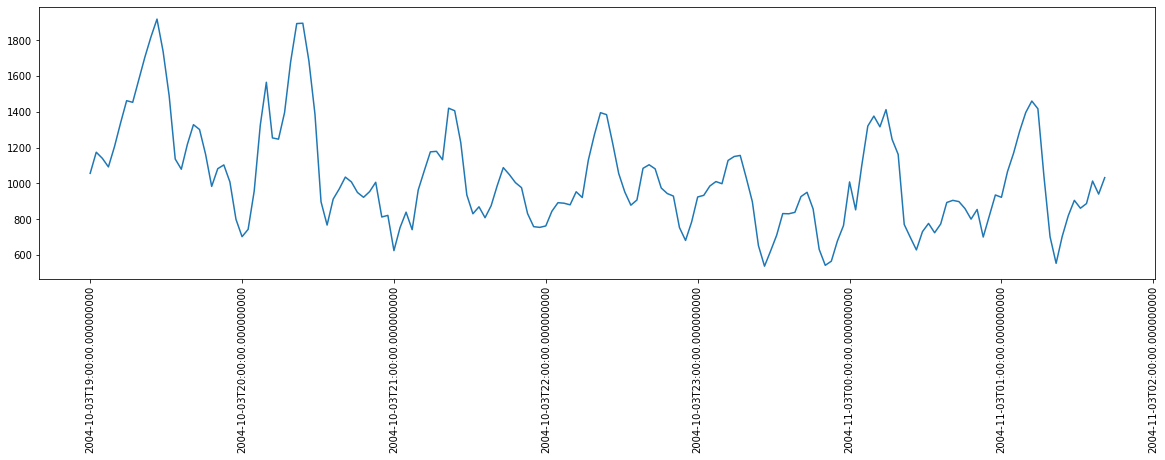

In [165]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(range(0,168),df['NOx'].values[0:168])
ax.set_xticklabels(df['Period'].values[0:168], rotation=90)

[Text(0, 0, '2004-10-03T18:00:00.000000000'),
 Text(0, 0, '2004-10-03T19:00:00.000000000'),
 Text(0, 0, '2004-10-03T20:00:00.000000000'),
 Text(0, 0, '2004-10-03T21:00:00.000000000'),
 Text(0, 0, '2004-10-03T22:00:00.000000000'),
 Text(0, 0, '2004-10-03T23:00:00.000000000'),
 Text(0, 0, '2004-11-03T00:00:00.000000000')]

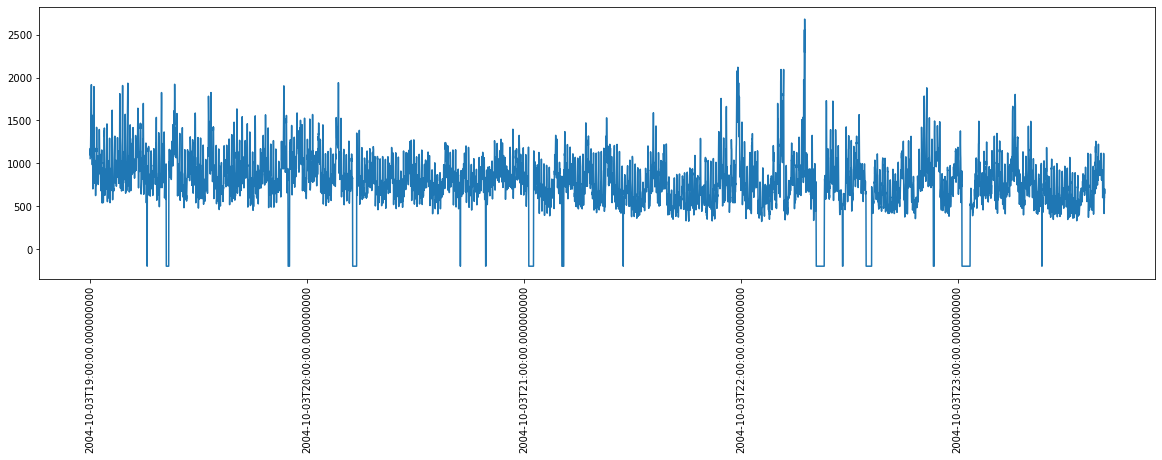

In [5]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(range(0,9357),df['NOx'].values)
ax.set_xticklabels(df['Period'].values, rotation=90)

In [6]:
adfuller(df['NOx'])

(-10.709339924536506,
 3.363197093089726e-19,
 38,
 9318,
 {'1%': -3.431051985659412,
  '5%': -2.8618502334031457,
  '10%': -2.5669351321592124},
 113706.88708216322)

# Explore Data

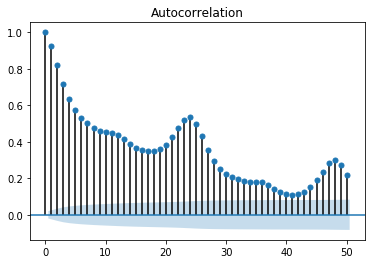

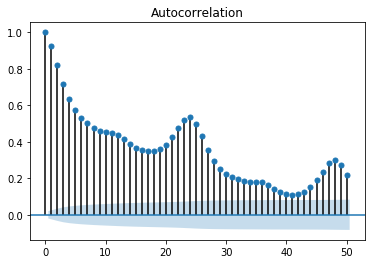

In [8]:
plot_acf(df['NOx'], alpha=.05, lags = 50)

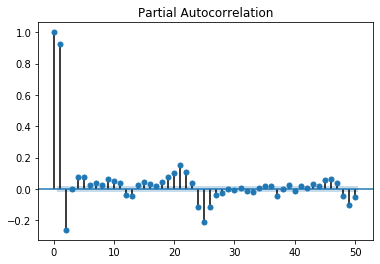

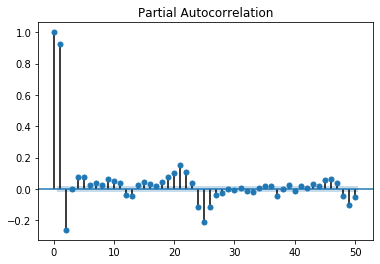

In [9]:
plot_pacf(df['NOx'], alpha=.05, lags = 50)

# Model Data

Perform Train Test Split

In [18]:
train_series = df['NOx'].values[:-1488]
val_series = df['NOx'].values[-1488:]

Calculate Persistance RMSE

In [45]:
train_predictions = train_series[0:-1]
train_actuals = train_series[1:]
val_predictions = val_series[0:-1]
val_actuals = val_series[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals, val_predictions)))
print('Validation MAE:', mean_absolute_error(val_actuals, val_predictions))

Train RMSE: 126.58770377218391
Train MAE: 81.65391459074733
Validation RMSE: 104.77756244763502
Validation MAE: 71.81573638197713


In [36]:
train_predictions

array([1056., 1174., 1140., ...,  466.,  479.,  497.])

In [37]:
train_actuals

array([1174., 1140., 1092., ...,  479.,  497.,  487.])

In [40]:
errors = train_predictions - train_actuals
errors_squared = np.square(errors)
np.mean(errors_squared)

16024.446746314185

In [42]:
print('Validation RMSE:', mean_absolute_error(val_actuals, val_predictions))

Validation RMSE: 71.81573638197713


In [43]:
print('Validation RMSE:', mean_squared_error(val_actuals, val_predictions))

Validation RMSE: 10978.337592468057


Build SARIMA model

In [31]:
sarima = SARIMAX(train_series, order = (3,0,3), seasonal_order = (1,0,1,24))
sarima_model = sarima.fit()
print(sarima_model.summary())
print(sarima_model.params)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 7869
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 24)   Log Likelihood              -47930.929
Date:                              Fri, 23 Oct 2020   AIC                          95879.859
Time:                                      11:58:29   BIC                          95942.595
Sample:                                           0   HQIC                         95901.350
                                             - 7869                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1373      0.036     31.907      0.000       1.067       1.207
ar.L2          0.58

In [46]:
val_pred_sarima = sarima_model.forecast(steps=1488)
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_sarima)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_sarima))

Validation RMSE: 283.96276884888647
Validation MAE: 187.30015389978382


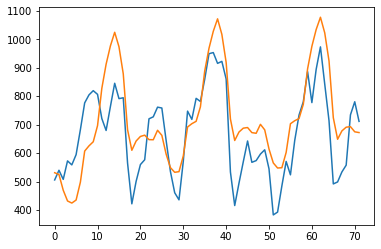

In [30]:
fig, ax = plt.subplots()
ax.plot(range(0,72),val_series[0:72])
ax.plot(range(0,72),val_pred_sarima[0:72])

Build Facebook Prophet Model

In [51]:
fb_df = df
fb_df.columns = ['ds','y']
prophet = Prophet(interval_width=0.95)
prophet.fit(fb_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [106]:
prophet_dates_df = prophet.make_future_dataframe(periods=1488, freq='H')
prophet_preds_df = prophet.predict(df=prophet_dates_df)

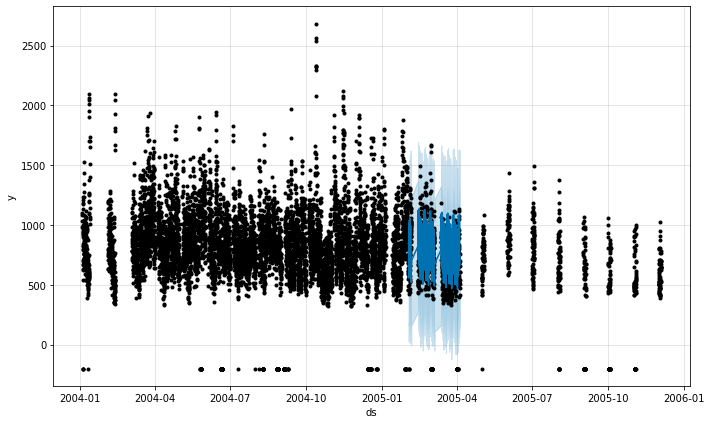

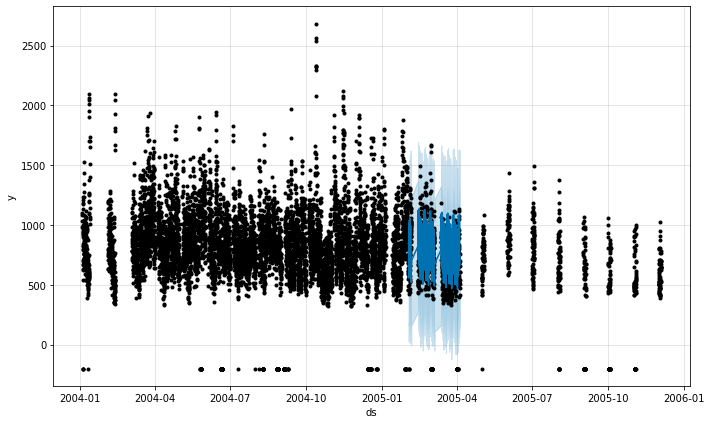

In [117]:
prophet.plot(prophet_preds_df)

In [101]:
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_prophet)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_prophet))

ValueError: Found input variables with inconsistent numbers of samples: [1488, 1632]

In [97]:
df.iloc[-1488:]

,Period,NOx
7869,2005-01-02 15:00:00,506.0
7870,2005-01-02 16:00:00,540.0
7871,2005-01-02 17:00:00,508.0
7872,2005-01-02 18:00:00,573.0
7873,2005-01-02 19:00:00,559.0
...,...,...
9352,2005-04-04 10:00:00,539.0
9353,2005-04-04 11:00:00,604.0
9354,2005-04-04 12:00:00,603.0
9355,2005-04-04 13:00:00,702.0


In [105]:
prophet_preds_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7149,2005-01-02 15:00:00,778.947097,294.520363,1397.611661,778.947097,778.947097,61.609149,61.609149,61.609149,-19.817209,-19.817209,-19.817209,81.426359,81.426359,81.426359,0.0,0.0,0.0,840.556246
7150,2005-01-02 16:00:00,778.934259,259.324706,1326.087456,778.934259,778.934259,42.078607,42.078607,42.078607,-39.834093,-39.834093,-39.834093,81.912700,81.912700,81.912700,0.0,0.0,0.0,821.012866
7151,2005-01-02 17:00:00,778.921421,246.068829,1304.256936,778.921421,778.921421,-5.947877,-5.947877,-5.947877,-88.244263,-88.244263,-88.244263,82.296386,82.296386,82.296386,0.0,0.0,0.0,772.973544
7152,2005-01-02 18:00:00,778.908583,202.706380,1252.775226,778.908583,778.908583,-60.998030,-60.998030,-60.998030,-143.580792,-143.580792,-143.580792,82.582762,82.582762,82.582762,0.0,0.0,0.0,717.910554
7153,2005-01-02 19:00:00,778.895745,149.627504,1232.601335,778.895745,778.895745,-85.921789,-85.921789,-85.921789,-168.697810,-168.697810,-168.697810,82.776022,82.776022,82.776022,0.0,0.0,0.0,692.973957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8776,2005-04-04 10:00:00,702.878965,99.800864,1228.923631,702.878965,702.878965,-17.310992,-17.310992,-17.310992,-91.075897,-91.075897,-91.075897,73.764904,73.764904,73.764904,0.0,0.0,0.0,685.567973
8777,2005-04-04 11:00:00,702.837615,184.951101,1259.109720,702.837615,702.837615,16.752070,16.752070,16.752070,-55.384884,-55.384884,-55.384884,72.136954,72.136954,72.136954,0.0,0.0,0.0,719.589685
8778,2005-04-04 12:00:00,702.796265,178.736673,1276.598341,702.796265,702.796265,34.377014,34.377014,34.377014,-35.964398,-35.964398,-35.964398,70.341412,70.341412,70.341412,0.0,0.0,0.0,737.173280
8779,2005-04-04 13:00:00,702.754915,184.947085,1276.735561,702.754915,702.754915,39.834710,39.834710,39.834710,-28.537895,-28.537895,-28.537895,68.372605,68.372605,68.372605,0.0,0.0,0.0,742.589625


In [104]:
df.iloc[-1488:].head(50)

,Period,NOx
7869,2005-01-02 15:00:00,506.0
7870,2005-01-02 16:00:00,540.0
7871,2005-01-02 17:00:00,508.0
7872,2005-01-02 18:00:00,573.0
7873,2005-01-02 19:00:00,559.0
7874,2005-01-02 20:00:00,595.0
7875,2005-01-02 21:00:00,683.0
7876,2005-01-02 22:00:00,777.0
7877,2005-01-02 23:00:00,805.0
7878,2005-02-02 00:00:00,820.0


In [115]:
prophet_preds_df = prophet_preds_df[prophet_preds_df['ds']>='2005-01-02 15:00:00']
prophet_preds_df = prophet_preds_df[prophet_preds_df['ds']<='2005-04-04 14:00:00']

In [116]:
prophet_preds_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7677,2005-02-01 15:00:00,764.200989,162.068827,1246.703943,764.200989,764.200989,-46.135242,-46.135242,-46.135242,-19.817209,-19.817209,-19.817209,-26.318033,-26.318033,-26.318033,0.0,0.0,0.0,718.065746
7678,2005-02-01 16:00:00,764.159639,174.004535,1253.227476,764.159639,764.159639,-69.417698,-69.417698,-69.417698,-39.834093,-39.834093,-39.834093,-29.583604,-29.583604,-29.583604,0.0,0.0,0.0,694.741941
7679,2005-02-01 17:00:00,764.118289,91.057545,1199.495651,764.118289,764.118289,-120.859734,-120.859734,-120.859734,-88.244263,-88.244263,-88.244263,-32.615471,-32.615471,-32.615471,0.0,0.0,0.0,643.258555
7680,2005-02-01 18:00:00,764.076939,24.955321,1126.817433,764.076939,764.076939,-178.975821,-178.975821,-178.975821,-143.580792,-143.580792,-143.580792,-35.395029,-35.395029,-35.395029,0.0,0.0,0.0,585.101118
7681,2005-02-01 19:00:00,764.035589,29.920472,1063.824877,764.035589,764.035589,-206.603471,-206.603471,-206.603471,-168.697810,-168.697810,-168.697810,-37.905661,-37.905661,-37.905661,0.0,0.0,0.0,557.432118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8776,2005-04-04 10:00:00,702.878965,152.674652,1218.385500,702.878965,702.878965,-17.310992,-17.310992,-17.310992,-91.075897,-91.075897,-91.075897,73.764904,73.764904,73.764904,0.0,0.0,0.0,685.567973
8777,2005-04-04 11:00:00,702.837615,237.533249,1246.190739,702.837615,702.837615,16.752070,16.752070,16.752070,-55.384884,-55.384884,-55.384884,72.136954,72.136954,72.136954,0.0,0.0,0.0,719.589685
8778,2005-04-04 12:00:00,702.796265,173.756920,1307.120345,702.796265,702.796265,34.377014,34.377014,34.377014,-35.964398,-35.964398,-35.964398,70.341412,70.341412,70.341412,0.0,0.0,0.0,737.173280
8779,2005-04-04 13:00:00,702.754915,224.507679,1254.322026,702.754915,702.754915,39.834710,39.834710,39.834710,-28.537895,-28.537895,-28.537895,68.372605,68.372605,68.372605,0.0,0.0,0.0,742.589625
